Comparison of F1-score, Hamming distance, and ARI results across different methods (ClustRecNet, Silhouette, CH, DB, and Dunn CVIs) on the synthetic test data. For detailed explanation refer to Section 3.1 "Experiments with Synthetic Data" in the paper.

### Imports

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, hamming_loss
from src.clust_utils import pad_symmetric
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
from src.training.models import CNNResNetAttention
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Load the required data
dataset = np.load("../data/test/features.npy", allow_pickle=True)
ground_truth = np.load("../data/test/ground_truth_labels.npy", allow_pickle=True)
predictions = np.load("../data/test/algorithm_predictions.npy", allow_pickle=True)
ari_scores = np.load("../data/test/ari_scores.npy", allow_pickle=True)

score_names = ["sil_scores", "ch_scores", "db_scores", "dunn_scores"]
loaded_scores = {
    name.replace("_scores", ""): np.load(os.path.join("../data/test/", f"{name}.npy"), allow_pickle=True)
    for name in score_names
}
ari_binary = [(np.array(ari) > 0.8).astype(int) for ari in ari_scores]
y_true = np.concatenate(ari_binary)

### Sensetivity Analysis

In [4]:
# Thresholds
thresholds = {
    'sil': [0.35, 0.4, 0.45, 0.5, 0.55],
    'ch': [120, 140, 160, 180, 200],
    'db': [0.4, 0.5, 0.6, 0.7, 0.8],
    'dunn': [0.4, 0.5, 0.6, 0.7, 0.8]
}

higher_is_better = {
    'sil': True,
    'ch': True,
    'db': False,
    'dunn': True
}

# Evaluation results
metric_eval_results = {}

for metric_name, scores in loaded_scores.items():
    result = []
    for th in thresholds[metric_name]:
        preds_bin = []
        for score in scores:
            if higher_is_better[metric_name]:
                preds_bin.append((np.array(score) >= th).astype(int))
            else:
                preds_bin.append((np.array(score) <= th).astype(int))
        y_pred = np.concatenate(preds_bin)
        f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)
        hamming = hamming_loss(y_true, y_pred)
        result.append((th, round(f1, 4), round(hamming, 4)))
    metric_eval_results[metric_name] = result

In [5]:
# Preserve order: Silhouette, CH, DB, Dunn
final_f1s = []
final_hammings = []
best_thresholds = {}

for metric_name, eval_results in metric_eval_results.items():
    best_row = max(eval_results, key=lambda x: x[1])  # based on F1
    best_thresholds[metric_name] = best_row[0]
    final_f1s.append(best_row[1])
    final_hammings.append(best_row[2])

In [6]:
# Extract and pad per metric
max_len = max(len(eval_results) for _, eval_results in metric_eval_results.items())

def pad(lst, target_len):
    return lst + [("", "", "")] * (target_len - len(lst))

metric_data = [pad(eval_results, max_len) for _, eval_results in metric_eval_results.items()]

# Build columns
columns = pd.MultiIndex.from_tuples([
    ("Silhouette", "Threshold"), ("Silhouette", "F1-score"), ("Silhouette", "Hamming"),
    ("Calinski-Harabasz", "Threshold"), ("Calinski-Harabasz", "F1-score"), ("Calinski-Harabasz", "Hamming"),
    ("Davies-Bouldin", "Threshold"), ("Davies-Bouldin", "F1-score"), ("Davies-Bouldin", "Hamming"),
    ("Dunn", "Threshold"), ("Dunn", "F1-score"), ("Dunn", "Hamming"),
])

# Build DataFrame rows
data = []
for i in range(max_len):
    row = []
    for metric_vals in metric_data:
        t, f1, ham = metric_vals[i]
        row.extend([t, f1, ham])
    data.append(row)

final_table = pd.DataFrame(data, columns=columns)
print(final_table)

  Silhouette                  Calinski-Harabasz                   \
   Threshold F1-score Hamming         Threshold F1-score Hamming   
0       0.35   0.6987  0.3013               120   0.6597  0.3403   
1       0.40   0.7106  0.2894               140   0.6634  0.3366   
2       0.45   0.7155  0.2845               160   0.6679  0.3321   
3       0.50   0.7128  0.2872               180   0.6670  0.3330   
4       0.55   0.7017  0.2983               200   0.6651  0.3349   

  Davies-Bouldin                       Dunn                   
       Threshold F1-score Hamming Threshold F1-score Hamming  
0            0.4   0.6512  0.3488       0.4   0.6151  0.3849  
1            0.5   0.6616  0.3384       0.5   0.6344  0.3656  
2            0.6   0.6793  0.3207       0.6   0.6360  0.3640  
3            0.7   0.6730  0.3270       0.7   0.6334  0.3666  
4            0.8   0.6545  0.3455       0.8   0.6329  0.3671  


### Proposed Model Prediction

In [ ]:
# Load Models:
cnnresatt_model = CNNResNetAttention()
cnnresatt_model.load_state_dict(torch.load('../artifacts/models/cnnresatt.pth', map_location=device))
cnnresatt_model.to(device)
cnnresatt_model.eval()

# Batch Data
all_X_padded = []
all_true_ari = []

padded_X = {}

for i in tqdm(range(len(dataset))):
    data_i = dataset[i]
    ari_i = ari_binary[i]
    padded = pad_symmetric(data_i)
    X_pad = padded[np.newaxis, np.newaxis, :, :]  # → (1, 1, 2000, 50)
    all_X_padded.append(X_pad)
    all_true_ari.append(ari_i[np.newaxis, :])  # → (1, 10)


# Convert to tensors and batch
X_tensor = torch.tensor(np.vstack(all_X_padded)).float()
y_tensor = torch.tensor(np.vstack(all_true_ari)).float()
val_dataset = TensorDataset(X_tensor, y_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Run model on all data
y_pred_model = []
preds = []
with torch.no_grad():
    for x_batch, _ in val_loader:
        x_batch = x_batch.to(device)
        pred = cnnresatt_model(x_batch)  # shape (batch, 10)
        preds.append(pred)  # Store raw predictions for further analysis
        binary_preds = (torch.sigmoid(pred) > 0.5).cpu().numpy() 
        y_pred_model.append(binary_preds)

# Final model predictions 
y_pred_model = np.vstack(y_pred_model)
preds = np.vstack(preds)

100%|██████████| 3400/3400 [00:00<00:00, 6673.73it/s]


In [8]:
y_true = y_true.reshape(-1, 10)  # Ensure y_true is in the correct shape

f1_model = f1_score(y_true, y_pred_model, average='micro')
hamming_model = hamming_loss(y_true, y_pred_model)

# Add to results
final_f1s.append(f1_model)
final_hammings.append(hamming_model)

# Reorder metrics accordingly
final_f1s = [f1_model] + final_f1s[:-1]
final_hammings = [hamming_model] + final_hammings[:-1]

### Comparison of Performance on Synthetic Data

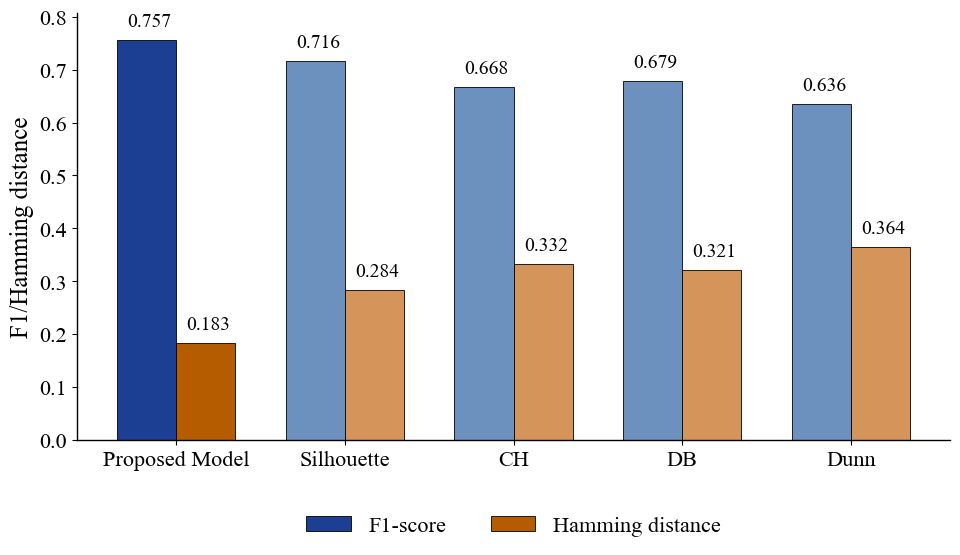

In [9]:
# Data
labels = ['Proposed Model', 'Silhouette', 'CH', 'DB', 'Dunn']
x = np.arange(len(labels))
bar_width = 0.35

# Colors
f1_colors = ["#1C3F94"] + ["#6C91BF"] * 4
hamming_colors = ["#B65C00"] + ["#D4945A"] * 4

# ✅ Global style for Type 1 font and CMYK-safe output
plt.rcParams.update({
    "text.usetex": False,  # no LaTeX required
    "pdf.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times"],
    'font.size': 20,             # base font size
    'axes.labelsize': 20,        # axis label
    'xtick.labelsize': 12,       # x-axis ticks
    'ytick.labelsize': 16,       # y-axis ticks
    'legend.fontsize': 16,       # legend
})


# Plot
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - bar_width/2, final_f1s, bar_width, color=f1_colors, label='F1-score',
               edgecolor='black', linewidth=0.6)
bars2 = ax.bar(x + bar_width/2, final_hammings, bar_width, color=hamming_colors, label='Hamming distance',
               edgecolor='black', linewidth=0.6)

def annotate_bars(bars, fmt="{:.3f}"):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(fmt.format(height),
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(2, 7), textcoords="offset points",
                    ha='center', va='bottom', fontsize=14)

annotate_bars(bars1)
annotate_bars(bars2)

# Labels
ax.set_ylabel("F1/Hamming distance", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=16)
ax.set_ylim(0, max(max(final_f1s), max(final_hammings)) + 0.05)

# Clean style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), ncol=2, frameon=False)

plt.tight_layout()
plt.savefig("../results/synthetic_performance.pdf", dpi=600, bbox_inches='tight', backend='cairo')
plt.show()

### K-fold on Synthetic Test Data (refer to Table 1 in the paper)

In [ ]:
# === Metrics to evaluate ===
metrics_all = ["model"] + list(loaded_scores.keys())
f1s_dict = {m: [] for m in metrics_all}
hamming_dict = {m: [] for m in metrics_all}
ari_from_best_idx = {m: [] for m in metrics_all}

# === 10-fold Cross-validation ===
kf = KFold(n_splits=10, shuffle=True, random_state=0)

for fold_idx, (_, test_idx) in enumerate(kf.split(dataset)):

    # Ground truth for F1/Hamming (flattened)
    y_true_bin = np.concatenate([ari_binary[i] for i in test_idx])

    for metric_name in loaded_scores.keys():
        scores = loaded_scores[metric_name]

        # === Step 1: Binary classification via thresholding ===
        best_f1 = -1
        best_preds_bin = None

        for th in thresholds[metric_name]:
            preds_bin = []
            for i in test_idx:
                score_vec = np.array(scores[i])
                pred = (score_vec >= th) if higher_is_better[metric_name] else (score_vec <= th)
                preds_bin.append(pred.astype(int))
            y_pred = np.concatenate(preds_bin)
            f1 = f1_score(y_true_bin, y_pred, average='micro', zero_division=0)

            if f1 > best_f1:
                best_f1 = f1
                best_preds_bin = y_pred

        f1s_dict[metric_name].append(best_f1)
        hamming_dict[metric_name].append(hamming_loss(y_true_bin, best_preds_bin))

        # === Step 2: ARI from best algorithm index ===
        best_ari_values = []
        for i in test_idx:
            score_vec = np.array(scores[i])
            best_idx = np.argmax(score_vec) if higher_is_better[metric_name] else np.argmin(score_vec)
            best_ari = ari_scores[i][best_idx]
            best_ari_values.append(best_ari)
        ari_from_best_idx[metric_name].append(np.mean(best_ari_values))

    # === Model Evaluation ===

    # Get predicted probabilities (raw model output)
    raw_preds_fold = preds[test_idx]  # shape: (N, 10)

    # Binary prediction: set only the argmax index to 1
    bin_preds_fold = y_pred_model[test_idx]

    # Ground truth for model evaluation
    y_true_model = np.vstack([ari_binary[i] for i in test_idx])

    # F1 and Hamming
    f1_model = f1_score(y_true_model, bin_preds_fold, average='micro')
    hamming_model = hamming_loss(y_true_model, bin_preds_fold)
    f1s_dict["model"].append(f1_model)
    hamming_dict["model"].append(hamming_model)

    # ARI from best predicted algorithm
    best_ari_model = []
    for idx, pred_row in zip(test_idx, raw_preds_fold):
        best_idx = np.argmax(pred_row)
        best_ari_model.append(ari_scores[idx][best_idx])
    ari_from_best_idx["model"].append(np.mean(best_ari_model))

# === Final Report ===
print("\n===== Cross-Validation Summary (Mean ± Std) per Metric =====")
print(f"{'Metric':>10} | {'F1-score':>13} | {'Hamming':>13} | {'ARI (from best index)':>13}")
print("-" * 80)

for metric in metrics_all:
    mean_f1 = np.mean(f1s_dict[metric])
    std_f1 = np.std(f1s_dict[metric])

    mean_ham = np.mean(hamming_dict[metric])
    std_ham = np.std(hamming_dict[metric])

    mean_ari = np.mean(ari_from_best_idx[metric])
    std_ari = np.std(ari_from_best_idx[metric])

    print(f"{metric.upper():>10} | {mean_f1:.3f} ± {std_f1:.3f} | {mean_ham:.3f} ± {std_ham:.3f} | {mean_ari:.3f} ± {std_ari:.3f}")


===== Cross-Validation Summary (Mean ± Std) per Metric =====
    Metric |      F1-score |       Hamming | ARI (from best index)
--------------------------------------------------------------------------------
     MODEL | 0.757 ± 0.017 | 0.183 ± 0.011 | 0.878 ± 0.007
       SIL | 0.720 ± 0.009 | 0.280 ± 0.009 | 0.365 ± 0.020
        CH | 0.669 ± 0.013 | 0.331 ± 0.013 | 0.381 ± 0.017
        DB | 0.681 ± 0.014 | 0.319 ± 0.014 | 0.344 ± 0.016
      DUNN | 0.637 ± 0.011 | 0.363 ± 0.011 | 0.280 ± 0.017
